In [194]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import peakutils
import json

In [195]:
ms2_mz_scaling_factor = 1000.0

In [196]:
db_name = 'z:/wilding-mcbride/processing/UPS2_200ng_2/UPS2_200ng_2-features-1-138.sqlite'
feature_id = 23
ms2_peak_id = 2

In [197]:
db_conn = sqlite3.connect(db_name)
db_conn.cursor().execute("CREATE INDEX IF NOT EXISTS idx_ms2_feature_region_points_1 ON ms2_feature_region_points (feature_id)")
db_conn.close()

In [198]:
# get the raw (unsummed) points the ms2 peaks mz belonging to a feature
db_conn = sqlite3.connect(db_name)
ms2_feature_region_points_df = pd.read_sql_query("select * from ms2_feature_region_points where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [199]:
len(ms2_feature_region_points_df)

547730

In [200]:
# get the ms2 peak summary information for this feature
db_conn = sqlite3.connect(db_name)
ms2_peaks_df = pd.read_sql_query("select * from ms2_peaks where feature_id={} order by peak_id ASC".format(feature_id), db_conn)
db_conn.close()

In [411]:
ms2_peaks_df[:5]

,feature_id,peak_id,centroid_mz,composite_mzs,centroid_scan,intensity
0,23,1,680.355,"[680328, 680329, 680330, 680331, 680332, 68033...",103,8965165
1,23,2,409.210,"[409193, 409194, 409195, 409196, 409197, 40919...",102,8569315
2,23,3,564.848,"[564830, 564831, 564832, 564833, 564834, 56483...",95,5145165
3,23,4,466.225,"[466210, 466211, 466212, 466213, 466214, 46621...",103,4891338
4,23,5,817.413,"[817383, 817384, 817385, 817386, 817387, 81738...",103,5047669


Need to get all the mzs used to create this peak

In [202]:
peak_composite_mzs = json.loads(ms2_peaks_df[ms2_peaks_df.peak_id == ms2_peak_id].composite_mzs[1])

In [412]:
peak_points = ms2_feature_region_points_df[ms2_feature_region_points_df.scaled_mz.isin(peak_composite_mzs)].sort_values(by=['scan'])
peak_points[:5]

,frame_id,mz,scan,intensity,point_id,scaled_mz,feature_id
4330,26457,409,92,425,871,409212,23
4331,26599,409,92,225,5209,409225,23
35572,26597,409,93,100,5912,409199,23
35573,26535,409,93,265,4026,409209,23
35574,26609,409,93,531,4950,409212,23


In [204]:
conv_db_name = 'z:/wilding-mcbride/processing/UPS2_200ng_2/UPS2_200ng_2.sqlite'

In [205]:
# calculate the ms2 frame rate - assume they alternate 
db_conn = sqlite3.connect(conv_db_name)
df = pd.read_sql_query("select value from convert_info where item=\'{}\'".format("raw_frame_period_in_msec"), db_conn)
raw_frame_period_in_msec = float(df.loc[0].value)
raw_frame_ids_per_second = 1.0 / (raw_frame_period_in_msec * 10**-3)
db_conn.close()

In [206]:
raw_frame_ids_per_second

50.0

In [207]:
peak_points.rename(columns = {'frame_id':'raw_frame_id'}, inplace = True)

In [208]:
peak_points['retention_time_secs'] = peak_points.raw_frame_id / raw_frame_ids_per_second

In [209]:
peak_points['marker_size'] = 10+1.5*np.log(peak_points.intensity*0.01)

In [413]:
peak_points[:5]

,frame_id,mz,scan,intensity,point_id,scaled_mz,feature_id
4330,26457,409,92,425,871,409212,23
4331,26599,409,92,225,5209,409225,23
35572,26597,409,93,100,5912,409199,23
35573,26535,409,93,265,4026,409209,23
35574,26609,409,93,531,4950,409212,23


In [211]:
centroid_scan = int(peakutils.centroid(peak_points.scan, peak_points.intensity))
centroid_scan

102

In [212]:
centroid_rt = peakutils.centroid(peak_points.retention_time_secs, peak_points.intensity)
centroid_rt

531.2231383558671

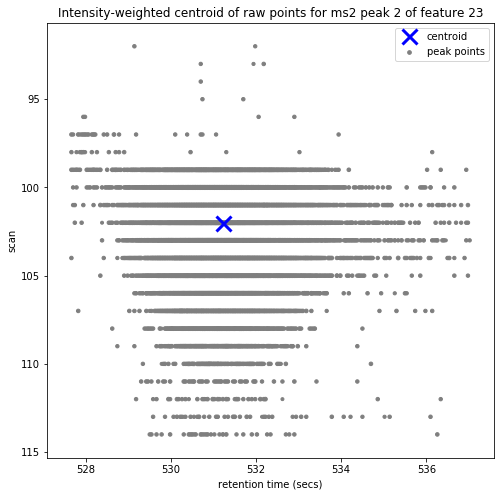

In [213]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax1.scatter(peak_points.retention_time_secs, peak_points.scan, marker='o', s=peak_points.marker_size, color='tab:gray', label='peak points')
plt.plot(centroid_rt, centroid_scan, 'bx', ms=15, mew=3, label='centroid')
plt.legend(loc='best')
ax1.set_ylabel('scan')
ax1.set_xlabel('retention time (secs)')
plt.title("Intensity-weighted centroid of raw points for ms2 peak {} of feature {}".format(ms2_peak_id,feature_id))
plt.gca().invert_yaxis()
plt.margins(0.06)
plt.show()

In [214]:
base_peak_id = 1

In [259]:
# get all the points the feature's summed ms1 region for this peak
db_conn = sqlite3.connect(db_name)
ms1_base_peak_points_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id={} and peak_id={}".format(feature_id, base_peak_id), db_conn)
db_conn.close()

In [389]:
ms1_base_peak_points_df[:5]

,feature_id,point_id,mz,scan,intensity,number_frames,peak_id,feature_point
0,23,1,509.266373,95,4765,6,1,23|1
1,23,2,509.270576,97,4065,6,1,23|2
2,23,3,509.268392,99,6217916,38,1,23|3
3,23,8,509.266796,100,34339260,42,1,23|8
4,23,13,509.267239,101,39648041,42,1,23|13


In [332]:
ms1_base_peak_points_df['feature_point'] = ms1_base_peak_points_df['feature_id'].map(str) + '|' + ms1_base_peak_points_df['point_id'].map(str)

In [390]:
ms1_base_peak_points_df[:5]

,feature_id,point_id,mz,scan,intensity,number_frames,peak_id,feature_point
0,23,1,509.266373,95,4765,6,1,23|1
1,23,2,509.270576,97,4065,6,1,23|2
2,23,3,509.268392,99,6217916,38,1,23|3
3,23,8,509.266796,100,34339260,42,1,23|8
4,23,13,509.267239,101,39648041,42,1,23|13


In [391]:
# get the mapping from feature points to summed frame points
db_conn = sqlite3.connect(db_name)
ms1_feature_frame_join_df = pd.read_sql_query("select * from ms1_feature_frame_join where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [392]:
ms1_feature_frame_join_df[:5]

,feature_id,feature_point_id,frame_id,frame_point_id
0,23,1,2648,2327
1,23,1,2649,2710
2,23,1,2650,3134
3,23,1,2651,3480
4,23,1,2652,3713


In [393]:
ms1_feature_frame_join_df['feature_point'] = ms1_feature_frame_join_df['feature_id'].map(str) + '|' + ms1_feature_frame_join_df['feature_point_id'].map(str)

In [394]:
ms1_feature_frame_join_df['frame_point'] = ms1_feature_frame_join_df['frame_id'].map(str) + '|' + ms1_feature_frame_join_df['frame_point_id'].map(str)

In [395]:
ms1_feature_frame_join_df[:5]

,feature_id,feature_point_id,frame_id,frame_point_id,feature_point,frame_point
0,23,1,2648,2327,23|1,2648|2327
1,23,1,2649,2710,23|1,2649|2710
2,23,1,2650,3134,23|1,2650|3134
3,23,1,2651,3480,23|1,2651|3480
4,23,1,2652,3713,23|1,2652|3713


In [396]:
frame_points = ms1_feature_frame_join_df.loc[ms1_feature_frame_join_df.feature_point.isin(ms1_base_peak_points_df.feature_point)]
frame_points[:5]

,feature_id,feature_point_id,frame_id,frame_point_id,feature_point,frame_point
0,23,1,2648,2327,23|1,2648|2327
1,23,1,2649,2710,23|1,2649|2710
2,23,1,2650,3134,23|1,2650|3134
3,23,1,2651,3480,23|1,2651|3480
4,23,1,2652,3713,23|1,2652|3713


In [399]:
frames_list = tuple(frame_points.frame_id.astype(int))
frame_point_list = tuple(frame_points.frame_point_id.astype(int))

In [400]:
# get the summed to raw point mapping
db_conn = sqlite3.connect(conv_db_name)
raw_point_ids_df = pd.read_sql_query("select * from raw_summed_join where summed_frame_id in {} and summed_point_id in {}".format(frames_list,frame_point_list), db_conn)
db_conn.close()

In [401]:
raw_point_ids_df['summed_frame_point'] = raw_point_ids_df['summed_frame_id'].map(str) + '|' + raw_point_ids_df['summed_point_id'].map(str)

In [402]:
raw_point_ids_df[:5]

,summed_frame_id,summed_point_id,raw_frame_id,raw_point_id,summed_frame_point
0,2639,679,26408,490,2639|679
1,2639,679,26418,504,2639|679
2,2639,683,26404,464,2639|683
3,2639,683,26430,506,2639|683
4,2639,684,26380,527,2639|684


In [403]:
raw_point_ids = raw_point_ids_df.loc[raw_point_ids_df.summed_frame_point.isin(frame_points.frame_point)]
raw_point_ids[:5]

,summed_frame_id,summed_point_id,raw_frame_id,raw_point_id,summed_frame_point
159,2639,870,26394,514,2639|870
160,2639,870,26424,425,2639|870
161,2639,870,26428,503,2639|870
162,2639,870,26430,567,2639|870
163,2639,870,26432,620,2639|870


In [404]:
len(raw_point_ids)

14097

In [405]:
raw_frame_list = tuple(raw_point_ids.raw_frame_id.astype(int))
raw_point_list = tuple(raw_point_ids.raw_point_id.astype(int))

In [406]:
# get the raw points
db_conn = sqlite3.connect(conv_db_name)
raw_points_df = pd.read_sql_query("select frame_id,point_id,mz,scan,intensity from frames where frame_id in {} and point_id in {}".format(raw_frame_list,raw_point_list), db_conn)
db_conn.close()

In [418]:
raw_points_df['marker_size'] = 10+1.5*np.log(raw_points_df.intensity*0.01)

In [419]:
raw_points_df.loc[(raw_points_df.frame_id==26432) & (raw_points_df.point_id==620)]

,frame_id,point_id,mz,scan,intensity,retention_time_secs,marker_size
16466,26432,620,509.267989,99,450,528.64,12.256116


In [414]:
raw_points_df['retention_time_secs'] = raw_points_df.frame_id / raw_frame_ids_per_second

In [410]:
centroid_scan = int(peakutils.centroid(raw_points_df.scan, raw_points_df.intensity))
centroid_scan

102

In [416]:
centroid_rt = peakutils.centroid(raw_points_df.retention_time_secs, raw_points_df.intensity)
centroid_rt

531.8875313668253

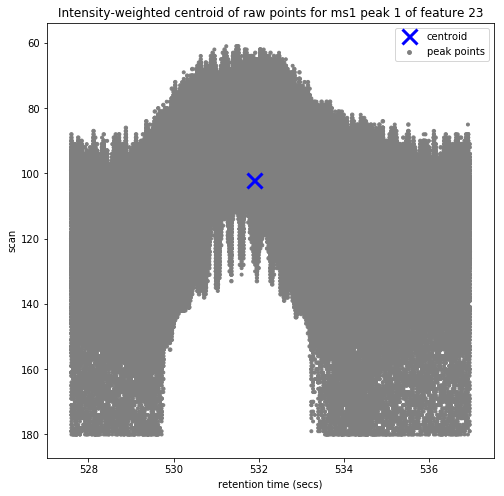

In [422]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax1.scatter(raw_points_df.retention_time_secs, raw_points_df.scan, marker='o', s=raw_points_df.marker_size, color='tab:gray', label='peak points')
plt.plot(centroid_rt, centroid_scan, 'bx', ms=15, mew=3, label='centroid')
plt.legend(loc='best')
ax1.set_ylabel('scan')
ax1.set_xlabel('retention time (secs)')
plt.title("Intensity-weighted centroid of raw points for ms1 peak {} of feature {}".format(base_peak_id,feature_id))
plt.gca().invert_yaxis()
plt.margins(0.06)
plt.show()